In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style(style='ticks')
import matplotlib.pyplot as plt
import seaborn as sns

import sys
sys.path.insert(0, '../induction_analysis')

from lab_repo.classes.dbclasses import dbExperiment, dbMouse
from lab_repo.misc.misc import calc_cdf

from scipy.stats import pearsonr, spearmanr, sem, ttest_ind
import numpy as np
import pandas as pd
import itertools as it

from scipy.ndimage.filters import gaussian_filter1d
import Analysis.induction_plots as ip

/home/sebi/code/analysis/analysis-scripts/induction_analysis/Analysis/induction_analysis.py:4: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/usr/lib/python2.7/runpy.py", line 174, in _run_module_as_main
    "__main__", fname, loader, pkg_name)
  File "/usr/lib/python2.7/runpy.py", line 72, in _run_code
    exec code in run_globals
  File "/home/sebi/.local/lib/python2.7/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/sebi/.local/lib/python2.7/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/sebi/.local/lib/python2.7/site-packages/ipykernel/kernelapp.py", line 499, in start
    self.io_loop.

In [2]:
mice = ['svr204', 'svr205', 'svr207', 'svr209', 'svr210', 'svr211']
mice = [dbMouse(m) for m in mice]

expts = []
for mouse in mice:
    expts.extend(mouse.imagingExperiments())

In [3]:
def paired_experiments(expts):
    
    ins = [x for x in expts if 'INs' in x.get('tSeriesDirectory')]
    pcs = [x for x in expts if 'PCs' in x.get('tSeriesDirectory')]
    
    def get_day(exp):
        return exp.get('startTime')[5:10]
    
    pc_fields = [(x.parent.mouse_name, get_day(x), x.get('LED')) for x in pcs]
    
    for in_expt in ins:
        in_field = (in_expt.parent.mouse_name, get_day(in_expt), in_expt.get('LED'))
        
        pc_idx = pc_fields.index(in_field)
        
        yield in_expt, pcs[pc_idx]
    

In [5]:
data_dir = '/home/sebi/data/induction/fig2/IN_'
save_dir = '/home/sebi/plots/ind/fig2/IN_'

## Plots

In [4]:
# Setup
from matplotlib import rc
plt.rcParams['axes.linewidth'] = 1
plt.rcParams['ytick.labelsize'] = 6
plt.rcParams['xtick.labelsize'] = 6
plt.rcParams['axes.labelsize'] = 7
plt.rcParams['boxplot.boxprops.linewidth'] = 1

rc('font',**{'family':'sans-serif','sans-serif':['helvetica', 'sans-serif']})
plt.rcParams['axes.unicode_minus'] = False

def clean(ax, full=False, offset=0):
    if full:
        sns.despine(ax=ax, left=True, bottom=True, offset=offset)
        ax.set_yticks([])
        ax.set_xticks([])
    else:
        sns.despine(ax=ax, offset=offset)

SpearmanrResult(correlation=0.5773117350714795, pvalue=0.0008370953913888823)


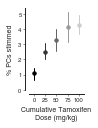

In [73]:
fig = plt.figure(figsize=(1, 1.5))
ax = fig.add_subplot(111)

sns.pointplot(x='session', y='pct_stimmed', hue='session', palette=['0', '0.2', '0.4', '0.6', '0.8'],
              data=subdf,
              ax=ax, edgecolor='k', scale=0.5, errwidth=1, ci=68)

clean(ax, offset=4)
ax.get_legend().remove()
ax.set_ylabel('% PCs stimmed')
ax.set_xlabel('Cumulative Tamoxifen\nDose (mg/kg)')

doses = [0, 125, 250, 375, 500] # uL
doses = [x / 5 for x in doses] # divide by 5 (assuming 20g mouse)
ax.set_xticklabels([str(x) for x in doses]);
ax.set_ylim([0, ax.get_ylim()[-1]])

# fig.savefig(save_dir + 'pct_vs_dose.svg', bbox_inches='tight')

print spearmanr(subdf['pct_stimmed'], subdf['session'])

(0.6549379054768972, 8.593956540025528e-05)
SpearmanrResult(correlation=0.6840934371523915, pvalue=3.069786600938953e-05)


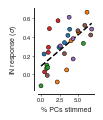

In [59]:
fig = plt.figure(figsize=(1, 1.5))
ax = fig.add_subplot(111)

sns.scatterplot(x='pct_stimmed', y='response', hue='mouse', data=subdf, s=16, edgecolor='k', legend=None, linewidth=0.5)
clean(ax, offset=4)
ax.set_xlabel('% PCs stimmed')
ax.set_ylabel(r'IN response ($\sigma$)')

pfit = np.polyfit(x=subdf['pct_stimmed'].values[:], y=subdf['response'].values[:], deg=1)
x = np.linspace(0, subdf['pct_stimmed'].max(), 3)
y = x * pfit[0] + pfit[1]
ax.plot(x, y, color='k', zorder=0, ls='--')

print pearsonr(subdf['pct_stimmed'], subdf['response'])
print spearmanr(subdf['pct_stimmed'], subdf['response'])

fig.savefig(save_dir + 'response_vs_pct_stimmed.svg', bbox_inches='tight')

In [71]:
paired_expts = list(paired_experiments(expts))

In [79]:
expt_pair_full = paired_expts[-2]
expt_pair_none = paired_expts[-10]

In [6]:
in_expts = [x for x in expts if np.all([k in x.get('tSeriesDirectory') for k in ['INs', 'svr211', '10-']])]

In [63]:
pc_expts = [x for x in expts if np.all([k in x.get('tSeriesDirectory') for k in ['PCs', 'svr211', '10-']])]

In [18]:
def response_psth(expt, pre=2, post=5, ax=None, color='k', label=None):
    
    sigs = expt.imagingData(dFOverF='from_file')[..., 0]
    sigs = (sigs - np.nanmean(sigs, axis=1, keepdims=True)) / np.nanstd(sigs, axis=1, keepdims=True)
    
    pre = int(2 / expt.frame_period())
    post = int(5 / expt.frame_period())

    stim_times = expt.behaviorData()['pin_13']
    stim_frames = (stim_times / expt.frame_period()).astype(int)[:, 0]

    responses = []

    for sig in sigs:

        # Mean Response per cell
        response = np.nanmean([sig[stim - pre:stim + post] for stim in stim_frames], axis=0)
        responses.append(response)

    print len(responses)
    response = np.nanmean(np.vstack(responses), axis=0)
    response_sem = sem(np.vstack(responses), axis=0)
    
    response -= np.nanmean(response[:pre])
    response = gaussian_filter1d(response, 2)
    response_sem = gaussian_filter1d(response_sem, 2)

    if not ax:
        fig = plt.figure()
        ax = fig.add_subplot(111)

    T = np.arange(-pre, post) * in_expt.frame_period()
    ax.fill_between(x=T, y1=response-response_sem, y2=response+response_sem, color=color, alpha=0.2)
    ax.plot(T, response, color=color, label=label)
    
    clean(ax, offset=4)
    
    ax.set_xlabel('')
    
    return ax

41
43
39
35
28


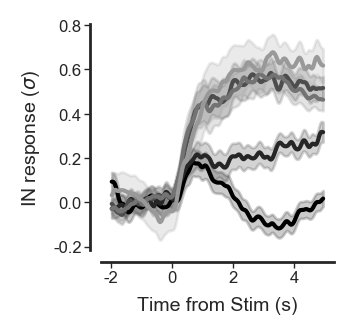

In [24]:
fig = plt.figure(figsize=(1.5, 1.5), dpi=200)
ax = fig.add_subplot(111)

# colors = ['0', '0.2', '0.4', '0.6', '0.8']
colors = ['0', '0.15', '0.3', '0.45', '0.6']

for in_expt, color, session in zip(in_expts, colors, range(1, 6)):
    response_psth(in_expt, ax=ax, color=color, label=session)
    
ax.set_ylabel(r'IN response ($\sigma$)')
ax.set_xlabel('Time from Stim (s)')
# ax.legend(title='Session')

fig.savefig(save_dir + 'example_psth_svr211_sem.svg', bbox_inches='tight')

In [9]:
## Data Functions

In [29]:
def response_sizes(expts):

    data_list = []

    for in_expt, pc_expt in paired_experiments(expts):

        # Get IN response
        stim_times = in_expt.behaviorData()['pin_13']
        stim_frames = (stim_times / in_expt.frame_period()).astype(int)[:, 0]

        sigs = in_expt.imagingData(dFOverF='from_file')[..., 0]
        sigs = (sigs - np.nanmean(sigs, axis=1, keepdims=True)) / np.nanstd(sigs, axis=1, keepdims=True)

        window = int(4 / in_expt.frame_period())

        vel = in_expt.velocity()[0]
        vel = (vel - np.nanmean(vel)) / np.nanstd(vel)
        vel_change = np.nanmean([vel[stim - window:stim + window] for stim in stim_frames])

        response_diffs = []
        for sig in sigs:

            # Mean Response per cell
            response = np.nanmean([sig[stim - window:stim + window] for stim in stim_frames], axis=0)
            response_diff = np.nanmean(response[window:]) - np.nanmean(response[:window])
            response_diffs.append(response_diff)

        response_mean = np.nanmean(response_diffs)
        response_std = np.nanstd(response_diffs)

        # Get N Stimmed PCs
        all_pcs = len(pc_expt.rois())
        stim_pcs = len(pc_expt.rois(roi_filter=lambda x: 'stimmed' in x.tags))


        data_list.append({'in_expt': in_expt.trial_id,
                          'pc_expt': pc_expt.trial_id,
                          'mouse': in_expt.parent.mouse_name,
                          'response': response_mean,
                          'response_std': response_std,
                          'vel_diff': vel_change,
                          'session': in_expt.session,
                          'LED': in_expt.LED,
                          'n_INs': len(in_expt.rois()),
                          'n_pcs': all_pcs,
                          'n_stimmed': stim_pcs,
                          'pct_stimmed': float(stim_pcs) / all_pcs})

    df = pd.DataFrame(data_list)
    
    return df

In [ ]:
response_df = response_sizes(expts)
response_df.to_pickle(data_dir + 'responses.pkl')

In [28]:
def in_differences(expts):
    
    data_list = []
    for in_expt, pc_expt in paired_experiments(expts):
        
        if in_expt.LED == 1:
            continue
        
        if in_expt.session > 0:
            continue

        mouse_name = in_expt.parent.mouse_name
        
        in_rois = in_expt.rois()
        ta = in_expt.imaging_dataset().time_averages[0, ..., 0]
        for roi in in_rois:
            mask = roi.mask[0].todense().astype(bool)
            intensity = np.nanmean(ta[mask])
            size = roi.mask[0].nnz * (0.64453125)**2
            
            
            data_list.append({'in_expt': in_expt.trial_id,
                              'pc_expt': pc_expt.trial_id,
                              'mouse': mouse_name,
                              'intensity': intensity,
                              'size': size,
                              'class': 'IN'})
        
        pc_rois = pc_expt.rois()
        ta = pc_expt.imaging_dataset().time_averages[0, ..., 0]
        for roi in pc_rois:
            mask = roi.mask[0].todense().astype(bool)
            intensity = np.nanmean(ta[mask])
            size = roi.mask[0].nnz * (0.64453125)**2
            
            data_list.append({'in_expt': in_expt.trial_id,
                              'pc_expt': pc_expt.trial_id,
                              'mouse': mouse_name,
                              'intensity': intensity,
                              'size': size,
                              'class': 'PC'})
    
    return pd.DataFrame(data_list)

In [30]:
morph_df = in_differences(expts)

In [31]:
morph_df.to_pickle(data_dir + 'morphology.pkl')

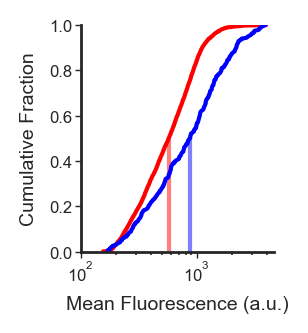

In [37]:
fig = plt.figure(figsize=(1.25, 1.5), dpi=200)
ax = fig.add_subplot(111)

bins, cdf_vals = calc_cdf(ax, morph_df.loc[morph_df['class']=='PC']['intensity'], color='r', label='PCs');
ax.vlines(ip.get_med(cdf_vals, bins), 0, 0.5, linestyles='-', color='r', alpha=0.5)
bins, cdf_vals = calc_cdf(ax, morph_df.loc[morph_df['class']=='IN']['intensity'], color='b', label='INs');
ax.vlines(ip.get_med(cdf_vals, bins), 0, 0.5, linestyles='-', color='b', alpha=0.5)

clean(ax)
ax.set_ylabel('Cumulative Fraction')
ax.set_xlabel(r'Mean Fluorescence (a.u.)')

ax.set_xscale('log')
ax.set_xticks([100, 1000])
fig.savefig('/home/sebi/plots/ind/figs2/IN_fluor.svg')

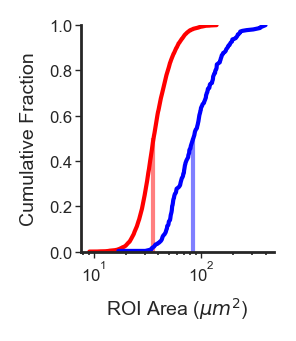

In [39]:
fig = plt.figure(figsize=(1.25, 1.5), dpi=200)
ax = fig.add_subplot(111)

bins, cdf_vals = cdf(ax, morph_df.loc[morph_df['class']=='PC']['size'], color='r', label='PCs');
ax.vlines(ip.get_med(cdf_vals, bins), 0, 0.5, linestyles='-', color='r', alpha=0.5)
bins, cdf_vals = cdf(ax, morph_df.loc[morph_df['class']=='IN']['size'], color='b', label='INs');
ax.vlines(ip.get_med(cdf_vals, bins), 0, 0.5, linestyles='-', color='b', alpha=0.5)

clean(ax)
ax.set_ylabel('Cumulative Fraction')
ax.set_xlabel(r'ROI Area ($\mu m^{2}$)')

ax.set_xscale('log')

fig.savefig('/home/sebi/plots/ind/figs2/IN_sizes.svg')

In [105]:
print morph_df.loc[morph_df['class']=='IN']['size'].mean(), morph_df.loc[morph_df['class']=='IN']['size'].sem()
print morph_df.loc[morph_df['class']=='PC']['size'].mean(), morph_df.loc[morph_df['class']=='PC']['size'].sem()
print ttest_ind(morph_df.loc[morph_df['class']=='IN']['size'], morph_df.loc[morph_df['class']=='PC']['size'])

100.422999385 3.3285847605964234
39.5567824949 0.23772288235079392
Ttest_indResult(statistic=48.3416367174921, pvalue=0.0)


In [106]:
print morph_df.loc[morph_df['class']=='IN']['intensity'].mean(), morph_df.loc[morph_df['class']=='IN']['intensity'].sem()
print morph_df.loc[morph_df['class']=='PC']['intensity'].mean(), morph_df.loc[morph_df['class']=='PC']['intensity'].sem()
print ttest_ind(morph_df.loc[morph_df['class']=='IN']['size'], morph_df.loc[morph_df['class']=='PC']['size'])
print ttest_ind(morph_df.loc[morph_df['class']=='IN']['intensity'], morph_df.loc[morph_df['class']=='PC']['intensity'])

1056.93158523 43.711017527428965
649.904250274 5.99209735258127
Ttest_indResult(statistic=48.3416367174921, pvalue=0.0)
Ttest_indResult(statistic=16.452495816122354, pvalue=4.455517829754509e-59)


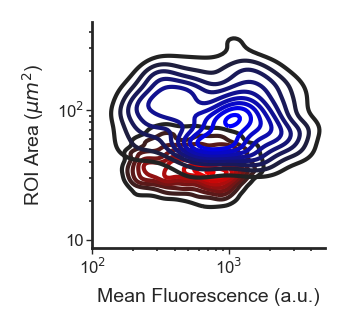

In [55]:
fig = plt.figure(figsize=(1.5, 1.5), dpi=200)
ax = fig.add_subplot(111)

# ax.set_yscale('log')
# ax.set_xscale('log')

test = morph_df.loc[morph_df['class'] == 'PC']
sns.kdeplot(data=np.log10(test['intensity']), data2=np.log10(test['size']), color='r', cut=1)
test = morph_df.loc[morph_df['class'] == 'IN']
sns.kdeplot(data=np.log10(test['intensity']), data2=np.log10(test['size']), color='b', cut=1)

clean(ax)
ax.set_xlabel(r'Mean Fluorescence (a.u.)')
ax.set_ylabel(r'ROI Area ($\mu m^{2}$)')

ax.set_xticks([2, 3])
minorxticks = np.hstack([np.arange(200, 1000, 100), np.arange(2000, 5000, 1000)])
ax.set_xticks([np.log10(x) for x in minorxticks], minor=True)
ax.set_xticklabels([r'10$^{2}$', r'10$^{3}$'])

ax.set_yticks([1, 2])
minoryticks = np.hstack([np.arange(20, 100, 10), np.arange(200, 500, 100)])
ax.set_yticks([np.log10(x) for x in minoryticks], minor=True)
ax.set_yticklabels(['10', r'10$^{2}$'])

# ax.set_xlim([4.5, 8.5])
fig.savefig('/home/sebi/plots/ind/figs2/IN_KDE.svg')